In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pymongo import ASCENDING, GEOSPHERE, MongoClient
import pandas as pd
from alive_progress import alive_bar
from shapely.geometry import Point, mapping
from keplergl import KeplerGl
import shapely
import json
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import geopandas as gpd
from h3 import h3
import math
import sklearn
import numpy as np
import time

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

from neighbour_embedding_methods import AverageDiminishingNeighbourEmbedding, AverageDiminishingSquqredNeighbourEmbedding, AverageNeighbourEmbedding, ConcatenateNeighbourEmbedding
from custom_distance_metric import DistanceMetric
from embedding_methods import BaseCountCategoryEmbedding, BaseShapeAnalyzerEmbedding, PerCategoryShapeAnalyzerEmbedding300
from embedding_methods import PerCategoryFilteredShapeAnalyzerEmbedding300

In [93]:
INBALANCE_RATIO = 5
RESOLUTION = 10
# NEIGHBORS = {
#     9: [0,1,2,3],
#     10: [0,2,4,6,8,10],1
#     11: [0,5,10,15,20,25]
# }
NEIGHBORS = 10
# NEIGHBORS = 0
CLASSIFIER = RandomForestClassifier
# NEIGHBORS_EMBEDDING_CLASS = ConcatenateNeighbourEmbedding
NEIGHBORS_EMBEDDING_CLASS = AverageDiminishingSquqredNeighbourEmbedding
EMBEDDING_CLASS = BaseCountCategoryEmbedding

In [5]:
client = MongoClient('mongodb://localhost:27017/')
db = client.osmDataDB
coll_cities = db.cities
coll_relations = db.relations

In [6]:
# city = coll_cities.find_one({'city': 'Wrocław'})
city = coll_cities.find_one({'city': 'Wrocław'})
train_city_1 = coll_cities.find_one({'city': 'Wrocław'})
train_city_2 = coll_cities.find_one({'city': 'Warszawa'})
train_city_3 = coll_cities.find_one({'city': 'Poznań'})

In [7]:
shp = shapely.geometry.shape(city['geometry'])

In [8]:
buffered_polygon = shp.buffer(0.005)

In [9]:
indexes = h3.polyfill(shapely.geometry.mapping(buffered_polygon), RESOLUTION, geo_json_conformant=False)

In [10]:
len(indexes)

41418

In [11]:
hexes = []
hexes_shp = []
for h in tqdm(indexes):
    polygons = h3.h3_set_to_multi_polygon([h], geo_json=False)
    outlines = [loop for polygon in polygons for loop in polygon]
    polyline = [outline + [outline[0]] for outline in outlines][0]
    polygon = shapely.geometry.Polygon(polyline)
    if shp.intersects(polygon):
        hexes.append({'hex_id': h, 'geometry': shapely.geometry.mapping(polygon)})
        hexes_shp.append({'hex_id': h, 'geometry': polygon})

100%|██████████| 41418/41418 [00:21<00:00, 1958.36it/s]


In [12]:
len(hexes)

36488

In [13]:
df = gpd.GeoDataFrame(hexes_shp)
df

,hex_id,geometry
0,8a524302daeffff,"POLYGON ((16.92769 51.12943, 16.92713 51.12969..."
1,8a52438d9b67fff,"POLYGON ((17.07880 51.15019, 17.07823 51.14983..."
2,8a524315d937fff,"POLYGON ((16.96501 51.16857, 16.96445 51.16884..."
3,8a5243171d57fff,"POLYGON ((17.02157 51.13177, 17.02213 51.13150..."
4,8a52438ebc87fff,"POLYGON ((17.13998 51.17182, 17.13941 51.17145..."
...,...,...
36483,8a5243166427fff,"POLYGON ((17.04904 51.13899, 17.04848 51.13862..."
36484,8a5243060ceffff,"POLYGON ((16.91283 51.19383, 16.91227 51.19409..."
36485,8a5243066167fff,"POLYGON ((16.91826 51.18118, 16.91770 51.18144..."
36486,8a5243176107fff,"POLYGON ((17.02565 51.09700, 17.02621 51.09737..."


In [15]:
df.to_file(f"wrocław_hexes_{RESOLUTION}.geojson", driver='GeoJSON')

In [34]:
def generate_xy(cites_ids, resolution, inbalance_ratio, neighbours, neighbour_embedding_cls, embedding_cls, id=None):
    client = MongoClient('mongodb://localhost:27017/')
    coll_hex = client.osmDataDB.hexesInCitiesFiltered
    relation_embedder = embedding_cls()
    relation_embedder.fit({ 'city_id': { '$in': cites_ids } })
    all_stations = [hex for hex in coll_hex.find({ 'city_id': { '$in': cites_ids }, 'has_station': True, 'resolution': resolution })]
    stations_length = len(all_stations)
    non_stations_cursor = coll_hex.aggregate([
        { '$match': { 'city_id': { '$in': cites_ids }, 'has_station': False, 'resolution': resolution } },
        { '$sample': { 'size': stations_length * inbalance_ratio } }
    ])
    non_stations = [hex for hex in non_stations_cursor]
    hex_id_list =  [h['hex_id'] for h in all_stations + non_stations]
    y = np.array([1] * stations_length + [0] * len(non_stations))
    # metric = DistanceMetric()
    # metric.fit({ 'city_id': { '$in': cites_ids } })
    y = np.array([1] * stations_length + [0] * len(non_stations))
    embedder = neighbour_embedding_cls(relation_embedder)
    vectors_list = [embedder.get_embedding(h, neighbours, relation_embedder) for h in tqdm(all_stations + non_stations, desc=f'[{id}] Embedding hexes {embedding_cls.__name__}')]
    # vectors = np.stack(vectors_list, axis=0)
    vectors = np.array(vectors_list)
    # vectors[np.isfinite(vectors) == True] = 0
    try:
        vectors[np.isnan(vectors) == True] = 0
    except:
        print(vectors)
    return vectors, y, hex_id_list

In [14]:
from functools import partial
from tqdm.contrib.concurrent import process_map 

relation_embedder = EMBEDDING_CLASS()
relation_embedder.fit({}, filtered = False)
embedder = NEIGHBORS_EMBEDDING_CLASS(relation_embedder)

def _embed(h):
    embedder.get_embedding(h, NEIGHBORS, relation_embedder, check_if_exists=False)
    return 0

def generate_x(hexes, neighbours, neighbour_embedding_cls, embedding_cls, id=None):
    relation_embedder = embedding_cls()
    relation_embedder.fit({}, filtered = False)
    embedder = neighbour_embedding_cls(relation_embedder)
    # _embed = partial(embedder.get_embedding, no_rings = neighbours, embedding_cls = relation_embedder, check_if_exists = False)
    # vectors_list = process_map(_embed, hexes, max_workers=16)
    vectors_list = [embedder.get_embedding(h, neighbours, relation_embedder, check_if_exists=False) for h in tqdm(hexes, desc=f'[{id}] Embedding hexes {embedding_cls.__name__}')]
    vectors = np.array(vectors_list)
    try:
        vectors[np.isnan(vectors) == True] = 0
    except:
        print(vectors)
    return vectors

In [15]:
def normalize_x(x):
    new_array = np.zeros(x.shape)
    # print(x.shape, new_array.shape)
    for i in tqdm(range(x.shape[1])):
        vector = x[:,i].reshape((-1,1))
        scaler = MinMaxScaler()
        new_array[:,i] = scaler.fit_transform(vector).reshape((-1,))
    return new_array

In [94]:
# train_cities_ids = [train_city_1['city_id'], train_city_2['city_id'], train_city_3['city_id']]
# train_cities_ids = [train_city_2['city_id'], train_city_3['city_id']]
train_cities_ids = [train_city_1['city_id']]
x, y, hex_ids = generate_xy(train_cities_ids, RESOLUTION, INBALANCE_RATIO, NEIGHBORS, NEIGHBORS_EMBEDDING_CLASS, EMBEDDING_CLASS)

[None] Embedding hexes BaseCountCategoryEmbedding: 100%|██████████| 1290/1290 [00:07<00:00, 171.51it/s]


In [17]:
wroclaw_x = generate_x(hexes, NEIGHBORS, NEIGHBORS_EMBEDDING_CLASS, EMBEDDING_CLASS)
# for n in range(NEIGHBORS):
#     wroclaw_x = generate_x(hsexes, n, NEIGHBORS_EMBEDDING_CLASS, EMBEDDING_CLASS)

[None] Embedding hexes BaseCountCategoryEmbedding: 100%|██████████| 36488/36488 [03:12<00:00, 189.97it/s]


In [95]:
normalized_x = normalize_x(x)
normalized_wroclaw_x = normalize_x(wroclaw_x)

100%|██████████| 20/20 [00:00<00:00, 488.48it/s]


In [148]:
normalized_all_x = normalize_x(np.vstack((x, wroclaw_x)))

100%|██████████| 36/36 [00:00<00:00, 46.68it/s]


In [149]:
normalized_x = normalized_all_x[:x.shape[0],:]
normalized_wroclaw_x = normalized_all_x[x.shape[0]:,:]

In [96]:
print(normalized_x.shape, normalized_wroclaw_x.shape)

(1290, 20) (36488, 20)


In [97]:
clf = CLASSIFIER()

In [98]:
clf.fit(normalized_x, y)

RandomForestClassifier()

In [99]:
clf.classes_

array([0, 1])

In [100]:
exists_index = list(clf.classes_).index(1)

In [101]:
wroc_y = clf.predict_proba(normalized_wroclaw_x)

In [102]:
wroc_y

array([[1.  , 0.  ],
       [0.93, 0.07],
       [0.97, 0.03],
       ...,
       [1.  , 0.  ],
       [0.97, 0.03],
       [0.85, 0.15]])

In [103]:
probs = wroc_y[:,1]
probs

array([0.  , 0.07, 0.03, ..., 0.  , 0.03, 0.15])

/home/raczeq/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

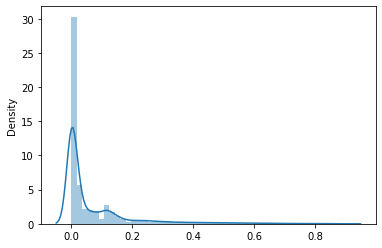

In [104]:
import seaborn as sns
sns.distplot(probs)

In [105]:
new_list = []
for h, y in zip(hexes_shp, wroc_y):
    h['probability'] = y[exists_index]
    new_list.append(h)

In [106]:
new_df = gpd.GeoDataFrame(new_list)

In [107]:
del new_df['hex_id']

In [108]:
new_df.to_file(f"wrocław_hexes_probability_{RESOLUTION}_cc_rf_imb{INBALANCE_RATIO}.geojson", driver='GeoJSON')

In [66]:
coll_areas = db.areas
swidnica = coll_areas.find_one({'osm_id': 3017761 })
shp = shapely.geometry.shape(swidnica['geometry'])
buffered_polygon = shp.buffer(0.005)
indexes = h3.polyfill(shapely.geometry.mapping(buffered_polygon), RESOLUTION, geo_json_conformant=False)

swidnica_hexes = []
swidnica_hexes_shp = []
for h in tqdm(indexes):
    polygons = h3.h3_set_to_multi_polygon([h], geo_json=False)
    outlines = [loop for polygon in polygons for loop in polygon]
    polyline = [outline + [outline[0]] for outline in outlines][0]
    polygon = shapely.geometry.Polygon(polyline)
    if shp.intersects(polygon):
        swidnica_hexes.append({'hex_id': h, 'geometry': shapely.geometry.mapping(polygon)})
        swidnica_hexes_shp.append({'hex_id': h, 'geometry': polygon})

100%|██████████| 3918/3918 [00:00<00:00, 5498.57it/s]


In [67]:
swidnica_x = generate_x(swidnica_hexes, NEIGHBORS, NEIGHBORS_EMBEDDING_CLASS, EMBEDDING_CLASS)

a52437b3baffff
No relations for hex 8a52437b3b1ffff
No relations for hex 8a5243786d37fff
No relations for hex 8a52437b3a6ffff
No relations for hex 8a52437b3b5ffff
No relations for hex 8a5243786c27fff
No relations for hex 8a5243786c07fff
No relations for hex 8a52437b3b57fff
No relations for hex 8a5243786d07fff
No relations for hex 8a52437b3b87fff
No relations for hex 8a52437b3a67fff
No relations for hex 8a52437b3b07fff
No relations for hex 8a52437b3ba7fff
No relations for hex 8a5243786d77fff
No relations for hex 8a52437b3b2ffff
No relations for hex 8a52437b3b77fff
No relations for hex 8a52437b169ffff
No relations for hex 8a5243786d27fff
No relations for hex 8a52437b1697fff
No relations for hex 8a5243786d57fff
No relations for hex 8a52437b3b4ffff
No relations for hex 8a5243786d2ffff
No relations for hex 8a5243786c0ffff
No relations for hex 8a52437b3bb7fff
No relations for hex 8a5243786c2ffff
No relations for hex 8a52437b3b47fff
No relations for hex 8a52437b3b17fff
No relations for hex 8a

In [74]:
normalized_x = normalize_x(x)
normalized_swidnica_x = normalize_x(swidnica_x)

100%|██████████| 20/20 [00:00<00:00, 3920.46it/s]


In [75]:
normalized_x.shape

(860, 20)

In [77]:
clf = CLASSIFIER()
clf.fit(normalized_x, y)
exists_index = list(clf.classes_).index(1)
swidnica_y = clf.predict_proba(normalized_swidnica_x)
new_list = []
for h, y in zip(swidnica_hexes_shp, swidnica_y):
    h['probability'] = y[exists_index]
    new_list.append(h)

new_df = gpd.GeoDataFrame(new_list)
del new_df['hex_id']
new_df.to_file(f"swidnica_hexes_probability_{RESOLUTION}_normalized_concatenate_based_on_wroclaw_inb{INBALANCE_RATIO}.geojson", driver='GeoJSON')